In [1]:
import pymongo
import pandas as pd
import numpy as np
import math
from datetime import datetime

# import dask.dataframe as dd ## 대규모 데이터 처리
# import vaex ## 대규모 데이터 처리

# from sklearn.linear_model import LinearRegression ## likes, dislikes 대체
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import os
from dotenv import load_dotenv

In [2]:
file_path = 'C:/py_src/awake/data/'

In [3]:
# 계정 / 콘텐츠 분석 데이터셋 불러오기
merge_df_users_fin = pd.read_csv('C:/py_src/awake/data/merge_df_users_fin.csv', low_memory=False)
youtube_videos = pd.read_csv(file_path + 'youtube_videos.csv')

## 계정 데이터 분석

### 기초통계

In [4]:
# 기초통계
merge_df_users_fin[merge_df_users_fin.columns[11:-16]].describe()

,views,redViews,UNSUBSCRIBED,SUBSCRIBED,comments,likes,shares,dislikes,estimatedMinutesWatched,averageViewDuration,averageViewPercentage,estimated_revenue,estimated_ad_revenue,estimated_red_partner_revenue,gross_revenue,cpm,playback_based_cpm,subscribers_count,subscribers_gained,subscribers_lost
count,1.056830e+05,1.056830e+05,1.056830e+05,1.056830e+05,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,1.056830e+05,105683.000000,1.056830e+05,105683.000000,105683.000000,1.056830e+05,105683.000000,105683.000000
mean,7.669704e+04,1.181762e+04,5.780240e+04,8.794060e+03,36.601629,3.968254e+03,122.175610,38.654117,8.683548e+04,2.590939,35.047682,2.877474e+04,1.501653e+04,3248.437925,2.722400e+04,5030.826465,5499.273283,6.988129e+04,125.901574,41.760690
std,9.172899e+05,6.232938e+04,7.977084e+05,1.190782e+05,326.696229,7.623700e+04,1486.124555,462.391495,8.077970e+05,6.506950,55.212625,1.318711e+05,6.781683e+04,13148.516236,1.231992e+05,22890.346092,6556.226151,1.789418e+05,1278.900197,348.199082
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.755000e+03,0.000000,-426.000000,0.000000e+00,0.000000,0.000000,-1.127185e+06,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3.290000e+02,8.700000e+01,9.100000e+01,3.000000e+00,0.000000,2.000000e+00,1.000000,0.000000,5.450000e+02,0.780000,16.680000,1.175040e+02,4.842900e+01,8.373500,8.782450e+01,24.000000,3232.250500,3.530000e+03,1.000000,1.000000
50%,1.844000e+03,4.900000e+02,9.020000e+02,7.600000e+01,1.000000,2.000000e+01,6.000000,1.000000,2.694000e+03,1.580000,28.000000,1.480631e+03,8.320230e+02,132.648000,1.504621e+03,328.000000,5155.512000,1.506600e+04,8.000000,5.000000
75%,1.212200e+04,3.405500e+03,6.649500e+03,8.305000e+02,9.000000,1.620000e+02,33.000000,5.000000,2.045400e+04,2.580000,47.680000,1.108485e+04,5.085199e+03,1021.478500,9.190117e+03,2119.000000,7229.389500,5.203100e+04,43.000000,22.000000
max,4.064898e+07,1.862117e+06,3.707229e+07,4.546611e+06,35931.000000,3.054524e+06,64529.000000,24353.000000,3.330760e+07,120.230000,15049.760000,5.338431e+06,3.082096e+06,388432.785000,5.601879e+06,994860.000000,489556.625000,3.442657e+06,77446.000000,18821.000000


In [5]:
# 잘못된값 처리
merge_df_users_fin['estimated_revenue'] = np.where(merge_df_users_fin['estimated_revenue'] < 0,
                                                   merge_df_users_fin['estimated_ad_revenue'] + merge_df_users_fin['estimated_red_partner_revenue'],
                                                   merge_df_users_fin['estimated_revenue'])

### 상관관계

In [6]:
# 상관관계
users_corr_matrix = merge_df_users_fin[merge_df_users_fin.columns[11:-16]].corr()
users_corr_matrix

,views,redViews,UNSUBSCRIBED,SUBSCRIBED,comments,likes,shares,dislikes,estimatedMinutesWatched,averageViewDuration,averageViewPercentage,estimated_revenue,estimated_ad_revenue,estimated_red_partner_revenue,gross_revenue,cpm,playback_based_cpm,subscribers_count,subscribers_gained,subscribers_lost
views,1.000000,0.887237,0.990442,0.943630,0.513510,0.989553,0.977800,0.988343,0.977856,-0.018855,0.037667,0.707427,0.527626,0.564268,0.528796,0.512862,0.015210,0.476780,0.945025,0.957050
redViews,0.887237,1.000000,0.852712,0.829370,0.505902,0.830601,0.835948,0.870122,0.871829,-0.036296,0.070093,0.746953,0.569576,0.670893,0.570658,0.574717,0.007111,0.567356,0.807065,0.830827
UNSUBSCRIBED,0.990442,0.852712,1.000000,0.936746,0.490312,0.985804,0.972716,0.976795,0.967478,-0.016759,0.044962,0.677054,0.511655,0.537700,0.512832,0.498079,0.015871,0.457118,0.947833,0.953924
SUBSCRIBED,0.943630,0.829370,0.936746,1.000000,0.529463,0.950954,0.921654,0.925751,0.945687,-0.011540,0.037588,0.769096,0.591106,0.603220,0.592372,0.569441,0.028896,0.535358,0.840056,0.905884
comments,0.513510,0.505902,0.490312,0.529463,1.000000,0.500979,0.497708,0.524899,0.503878,-0.019573,0.043904,0.439432,0.325125,0.350781,0.325862,0.323164,0.007777,0.312102,0.504283,0.524476
likes,0.989553,0.830601,0.985804,0.950954,0.500979,1.000000,0.984213,0.977959,0.970689,-0.013458,0.027295,0.680034,0.505728,0.524644,0.506934,0.484658,0.018521,0.441308,0.936573,0.951134
shares,0.977800,0.835948,0.972716,0.921654,0.497708,0.984213,1.000000,0.967875,0.964019,-0.006929,0.028528,0.686037,0.529940,0.542907,0.530864,0.506659,0.024675,0.447388,0.938846,0.945531
dislikes,0.988343,0.870122,0.976795,0.925751,0.524899,0.977959,0.967875,1.000000,0.962861,-0.020414,0.037492,0.692621,0.500523,0.548045,0.501676,0.484593,0.012684,0.452646,0.958289,0.962212
estimatedMinutesWatched,0.977856,0.871829,0.967478,0.945687,0.503878,0.970689,0.964019,0.962861,1.000000,0.082526,0.026288,0.788171,0.657877,0.669697,0.658758,0.630532,0.033969,0.524253,0.912208,0.939512
averageViewDuration,-0.018855,-0.036296,-0.016759,-0.011540,-0.019573,-0.013458,-0.006929,-0.020414,0.082526,1.000000,-0.042992,0.105156,0.146358,0.365298,0.145600,0.099347,0.078650,0.030085,-0.015928,-0.015658


In [7]:
# 버그로 사용된 수치값 대체
merge_df_users_fin['likes'] = np.where(merge_df_users_fin['likes'] < 0, 0, merge_df_users_fin['likes'])
merge_df_users_fin['dislikes'] = np.where(merge_df_users_fin['dislikes'] < 0, 0, merge_df_users_fin['dislikes'])

### 파생변수

In [8]:
# 파생변수1 - 참여도 관련
merge_df_users_fin['like_rate'] = merge_df_users_fin['likes'] / merge_df_users_fin['views'] ## 좋아요 비율 
merge_df_users_fin['comment_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['views'] ## 댓글 비율
merge_df_users_fin['share_rate'] = merge_df_users_fin['shares'] / merge_df_users_fin['views'] ## 공유 비율  
merge_df_users_fin['dislike_rate'] = merge_df_users_fin['dislikes'] / merge_df_users_fin['views'] ## 싫어요 비율
merge_df_users_fin['total_engage_rate'] = (merge_df_users_fin['likes'] + merge_df_users_fin['comments'] + merge_df_users_fin['shares']) / merge_df_users_fin['views'] ## 총 참여율
merge_df_users_fin['comment_to_like_rate'] = merge_df_users_fin['comments'] / merge_df_users_fin['likes'] ## 댓글/좋아요 비율

In [9]:
# 파생변수2 - 구독자 관련
merge_df_users_fin['subscriber_increase_rate'] = merge_df_users_fin['subscribers_gained'] / merge_df_users_fin['subscribers_count'] ## 구독자 증가율
merge_df_users_fin['subscriber_decrease_rate'] = merge_df_users_fin['subscribers_lost'] / merge_df_users_fin['subscribers_count'] ## 구독자 감소율
merge_df_users_fin['net_subscribers_change'] = merge_df_users_fin['subscribers_gained'] - merge_df_users_fin['subscribers_lost'] ## 구독자 순증가

In [10]:
# 파생변수3 - 수익 관련
merge_df_users_fin['revenue_per_view'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['views'] ## 조회수당 수익
merge_df_users_fin['ad_revenue_rate'] = merge_df_users_fin['estimated_ad_revenue'] / merge_df_users_fin['estimated_revenue'] ## 광고수익비율
merge_df_users_fin['red_revenue_rate'] = merge_df_users_fin['estimated_red_partner_revenue'] / merge_df_users_fin['estimated_revenue'] ## 프리미엄수익비율
merge_df_users_fin['cpm_to_revenue_ratio'] = merge_df_users_fin['cpm'] - merge_df_users_fin['estimated_revenue'] ## cpm 대비 수익
merge_df_users_fin['revenue_per_ad_impression'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['ad_impressions'] ## 광고노출당 수익
merge_df_users_fin['playback_based_cpm_rate'] = merge_df_users_fin['playback_based_cpm'] / merge_df_users_fin['cpm'] ## 재생 기반 수익

In [11]:
# 파생변수4 - 시청 시간 관련
merge_df_users_fin['revenue_per_minute_watched'] = merge_df_users_fin['estimated_revenue'] / merge_df_users_fin['estimatedMinutesWatched'] ## 시청 시간 당 수익
merge_df_users_fin['avg_view_duration_rate'] = merge_df_users_fin['averageViewDuration'] / merge_df_users_fin['averageViewPercentage'] ## 평균 시청 시간 비율
merge_df_users_fin['watched_time_rate'] = merge_df_users_fin['averageViewPercentage'] * merge_df_users_fin['estimatedMinutesWatched'] ## 재생 비율 대비 시청 시간

In [12]:
# 파생변수5 - 구독자 유형 관련
merge_df_users_fin['subscribed_view_time_rate'] = merge_df_users_fin['SUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## 구독자 시청 시간 비율
merge_df_users_fin['unsubscribed_view_time_rate'] = merge_df_users_fin['UNSUBSCRIBED'] / (merge_df_users_fin['SUBSCRIBED'] + merge_df_users_fin['UNSUBSCRIBED']) ## 비구독자 시청 시간 비율

In [13]:
# 파생변수6 - 연령 및 성별 관련
female_col = [col_nm for col_nm in merge_df_users_fin.columns if 'female' in col_nm ]
male_col = [col_nm for col_nm in merge_df_users_fin.columns if ('male' in col_nm) and ('female' not in col_nm)]

youth_col = [col_nm for col_nm in merge_df_users_fin.columns if '13-17' in col_nm]
adult_col = [col_nm for col_nm in merge_df_users_fin.columns if ('18-24' in col_nm) or ('25-34' in col_nm) or ('35-44' in col_nm) or ('45-54' in col_nm)]
older_col = [col_nm for col_nm in merge_df_users_fin.columns if ('55-64' in col_nm) or ('65' in col_nm)]

merge_df_users_fin['female_viewer_rate'] = merge_df_users_fin[female_col].sum(axis=1) ## 여성 시청자 비율
merge_df_users_fin['male_viewer_rate'] = merge_df_users_fin[male_col].sum(axis=1) ## 남성 시청자 비율

merge_df_users_fin['youth_viewer_rate'] = merge_df_users_fin[youth_col].sum(axis=1) ## 청소년 시청자 비율
merge_df_users_fin['adult_viewer_rate'] = merge_df_users_fin[adult_col].sum(axis=1) ## 성인 시청자 비율
merge_df_users_fin['older_viewer_rate'] = merge_df_users_fin[older_col].sum(axis=1) ## 노인 시청자 비율

### 시계열 확인
- Looker Studio 활용

In [14]:
# 'date' 컬럼을 datetime 형식으로 변환
merge_df_users_fin['date'] = pd.to_datetime(merge_df_users_fin['date'])

# 주(week) 컬럼 생성 (ISO 주 번호 기준)
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].dt.isocalendar().week
merge_df_users_fin['date_week'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_week'].astype(str)
merge_df_users_fin['date_week'] = pd.to_datetime(merge_df_users_fin['date_week'] + '-1', format='%Y-%W-%w') ## looker studio 날짜 형식 위해 주마다 월요일 날짜로 변경
merge_df_users_fin['date_week'] = merge_df_users_fin['date_week'].astype(str)

# 월(month) 컬럼 생성
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].dt.month
merge_df_users_fin['date_month'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_month'].fillna(0).astype(int).astype(str)
merge_df_users_fin['date_month'] = np.where(merge_df_users_fin['date_month']=='NaT-0','',merge_df_users_fin['date_month'])

# 분기(quarter) 컬럼 생성
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].dt.to_period('Q').dt.quarter
merge_df_users_fin['date_quarter'] = merge_df_users_fin['date'].astype(str).str.split('-').str[0] + '-' + merge_df_users_fin['date_quarter'].fillna(0).astype(str)
merge_df_users_fin['date_quarter'] = np.where(merge_df_users_fin['date_quarter']=='NaT--1','',merge_df_users_fin['date_quarter'])

In [15]:
merge_df_users_looker = merge_df_users_fin[['youtube_user_id','date','date_week','date_month','date_quarter','viewCount','subscriberCount','videoCount',
                                            'views','estimated_revenue','subscribers_count','estimatedMinutesWatched','averageViewDuration',
                                            'total_engage_rate','net_subscribers_change','averageViewPercentage','revenue_per_view',
                                            'female_viewer_rate', 'male_viewer_rate', 'youth_viewer_rate', 'adult_viewer_rate', 'older_viewer_rate']]

In [101]:
# merge_df_users_looker.to_csv('C:/py_src/awake/data/merge_df_users_looker.csv', encoding='utf-8-sig', index=False)

### y값 설정

#### 중요 지표 표준화

In [16]:
# y값 활용 지표
y_col = ['total_engage_rate', 'net_subscribers_change', 'averageViewPercentage', 'revenue_per_view'] ## null값은 views가 0인 데이터

In [17]:
# null값 대체
merge_df_users_fin[y_col] = merge_df_users_fin[y_col].fillna(0) ## NaN
merge_df_users_fin[y_col] = np.where(merge_df_users_fin[y_col]==np.inf,0,merge_df_users_fin[y_col]) ## inf

In [18]:
# 표준화 (Standard Scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merge_df_users_fin[y_col])

#### 다중 지표 결합

In [19]:
# Isolation Forest 모델 학습
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 이상치 비율 설정
iso_forest.fit(scaled_features)

# 이상치 점수 계산
anomaly_scores = iso_forest.decision_function(scaled_features)

In [21]:
# 임계값 설정
threshold = np.percentile(anomaly_scores, 5) ## 이상치 점수가 작을수록 이상치에 가깝다고 판단하는데, 5번째 백분위수가 (-)로 바뀌는 포인트

# y값 라벨링 (이상치이면 0, 그렇지 않으면 1)
merge_df_users_fin['y_label'] = np.where(anomaly_scores < threshold, 0, 1)

In [29]:
# 전체 데이터 y값 빈도 확인
merge_df_users_fin['y_label'].value_counts()

y_label
1    100398
0      5285
Name: count, dtype: int64

In [22]:
# 계정별 y값 빈도 데이터
y_result_df = merge_df_users_fin.groupby('youtube_user_id')['y_label'].value_counts().reset_index()
y_result_df

,youtube_user_id,y_label,count
0,627cb611aa6f212355e0b617,1,403
1,627cb611aa6f212355e0b617,0,2
2,627f59ccaa39226247c60b01,1,388
3,627f59ccaa39226247c60b01,0,17
4,6287228afb15712a8cb931d7,1,405
...,...,...,...
430,65f7b17ed8da110bb0733b7b,1,404
431,65f7b17ed8da110bb0733b7b,0,1
432,65fecf7ed8da110bb0736199,1,405
433,66230ee6d8da110bb0744b2d,1,366


In [67]:
# 계정별 일일데이터의 20% 이상 이상치 데이터인 계정 확인
y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 80]

,youtube_user_id,y_label,count
22,62872523fb15712a8cb93479,0,113
54,629f6ca6eaf5732d6df0611e,0,326
62,62a35ce69d41c93ff90b5670,0,168
148,639bb8dcd603b8138e33780b,0,203
231,640001db0abaa11316396d3b,0,154
242,64020bf4d746c60e1272055f,0,213
247,640339ac118c0f5858818694,0,261
298,645da9e6ef566f0e136a83cf,0,158
299,645ec17eef566f0e136a9880,0,233
368,64d964e4f638790e0f74a391,0,272


#### 개별 지표별 평가 종합

In [113]:
thresholds = {}
anomaly_scores_dict = {}

# 각 지표에 대해 개별 임계값 설정
for i, feature in enumerate(y_col):
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(scaled_features[:,i].reshape(-1, 1))
    anomaly_scores = iso_forest.decision_function(scaled_features[:,i].reshape(-1, 1))
    thresholds[feature] = np.percentile(anomaly_scores, 5)
    anomaly_scores_dict[feature] = anomaly_scores

In [116]:
merge_df_users_fin['y_label2'] = 1  # 기본값을 1로 설정 (진짜 영향력)

for feature in y_col:
    merge_df_users_fin['y_label2'] = np.where(anomaly_scores_dict[feature] < thresholds[feature], 0, merge_df_users_fin['y_label2'])

In [117]:
# 전체 데이터 y값 빈도 확인
merge_df_users_fin['y_label2'].value_counts()

y_label2
1    86658
0    19025
Name: count, dtype: int64

In [118]:
# 계정별 y값 빈도 데이터
y_result_df2 = merge_df_users_fin.groupby('youtube_user_id')['y_label2'].value_counts().reset_index()
y_result_df2

,youtube_user_id,y_label2,count
0,627cb611aa6f212355e0b617,1,399
1,627cb611aa6f212355e0b617,0,6
2,627f59ccaa39226247c60b01,1,328
3,627f59ccaa39226247c60b01,0,77
4,6287228afb15712a8cb931d7,1,405
...,...,...,...
485,65f7b17ed8da110bb0733b7b,0,6
486,65fecf7ed8da110bb0736199,1,399
487,65fecf7ed8da110bb0736199,0,6
488,66230ee6d8da110bb0744b2d,1,219


In [127]:
# 계정별 일일데이터의 20% 이상 이상치 데이터인 계정 확인
y_result_df2[y_result_df2['y_label2']==0][y_result_df2[y_result_df2['y_label2']==0]['count'] >= 80]

,youtube_user_id,y_label2,count
6,6287229efb15712a8cb93225,0,86
25,62872523fb15712a8cb93479,0,207
29,628727e1fb15712a8cb9353b,0,170
52,6294ab84fe241a32a48ada00,0,151
62,629f6ca6eaf5732d6df0611e,0,372
...,...,...,...
468,65a3f25864b4250ba696579a,0,236
477,65bbb4a905bf1c0baa41e95c,0,147
480,65cc401305bf1c0baa425146,0,159
483,65e7b773d8da110bb072e2b5,0,81


In [173]:
bb - aa

{'-mentalholder 멘탈홀더 tv',
 'MerryMa 메리마',
 'ORlGN 오리진',
 'the sence',
 '日本ジヌ【니혼지누】ー韓国に関する全て',
 '군대위키',
 '김밈서',
 '꾸앤끄',
 '나는미도',
 '나연이즈백 LPGA Na Yeon Choi',
 '단곰',
 '두남자 토익TV',
 '뚜니랑',
 '띠혜 ddihye',
 '래아TV',
 '맛집남자 foodman',
 '모염 moyeom',
 '목소리 연기자 유지컬',
 '바른걸음연구소',
 '밖비타',
 '석시원 커플 SeokSiWon Couple',
 '수빙수tv sooBingsoo',
 '수집의 수집',
 '슈로시안 SUROSIAN',
 '시골낭만아재',
 '신크TV',
 '에피코딩',
 '여정을떠난여정',
 '오디디 코미디',
 '윈플즈TV',
 '채찍단',
 '청어람ARMC',
 '축구 읽어주는 여자 쵱내',
 '키키낙낙',
 '태다린tae_darin',
 '탬니몰리',
 '핸슥슥',
 '황헬린 탈출기'}

In [163]:
len(y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]['youtube_user_id'].unique())

36

In [168]:
aa = set(merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(set(y_result_df[y_result_df['y_label']==0][y_result_df[y_result_df['y_label']==0]['count'] >= 40]['youtube_user_id']))]['channel_title'].unique())

In [169]:
bb = set(merge_df_users_fin[merge_df_users_fin['youtube_user_id'].isin(set(y_result_df2[y_result_df2['y_label2']==0][y_result_df2[y_result_df2['y_label2']==0]['count'] >= 80]['youtube_user_id']))]['channel_title'].unique())

#### 군집분석

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

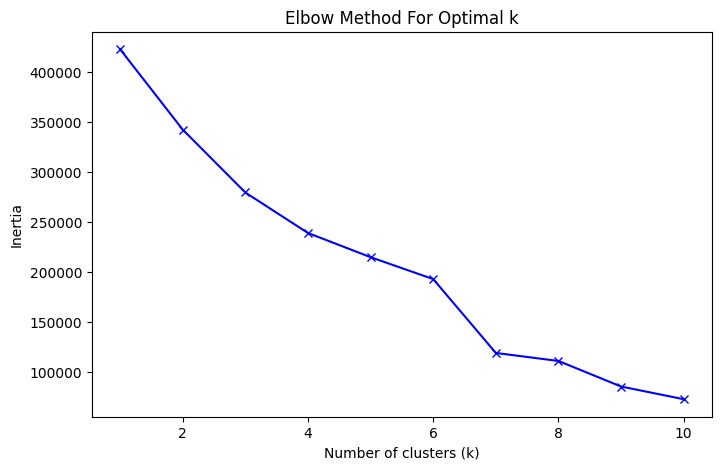

In [209]:
# 엘보우 기법을 사용해 적절한 클러스터 수 찾기
inertia = []
K = range(1, 11)  # 1부터 10까지의 클러스터 수를 테스트

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [232]:
# 최적 클러스터 수
optimal_k = 7

# K-Means 모델 학습
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# 각 데이터 포인트에 대한 클러스터 할당
merge_df_users_fin['cluster'] = kmeans.labels_

In [ ]:
# 클러스터별 빈도수 확인
merge_df_users_fin['cluster'].value_counts()

cluster
0    86508
1    18544
5      457
3      150
4       20
2        3
6        1
Name: count, dtype: int64

In [233]:
# 클러스터별 통계 확인
cluster_summary = merge_df_users_fin.groupby('cluster')[y_col].mean()
print(cluster_summary)

         total_engage_rate  net_subscribers_change  averageViewPercentage  \
cluster                                                                     
0                 0.014220               35.156147              35.311859   
1                 0.052491              137.950712              33.089701   
2                 0.028571               -1.000000               4.223333   
3                 0.088201            21934.033333              64.285259   
4                 0.031525               -1.450000              14.377500   
5                 0.253590                6.002188              23.145822   
6                 0.008531               -1.000000           15049.760000   

         revenue_per_view  
cluster                    
0                1.375209  
1                2.092675  
2             1705.123363  
3                0.098057  
4              484.261921  
5                1.749699  
6                0.000000  


In [238]:
# 클러스터별 y값 빈도수 확인1 - 다중 지표 활용
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label'].value_counts()
cluster_summary

cluster  y_label
0        1          84496
         0           2012
1        1          15902
         0           2642
2        0              3
3        0            150
4        0             20
5        0            457
6        0              1
Name: count, dtype: int64

In [246]:
# 클러스터별 y값 빈도수 확인2 - 개별 지표 종합
cluster_summary = merge_df_users_fin.groupby('cluster')['y_label2'].value_counts()
cluster_summary

cluster  y_label2
0        1           76080
         0           10428
1        1           10578
         0            7966
2        0               3
3        0             150
4        0              20
5        0             457
6        0               1
Name: count, dtype: int64

In [277]:
# 이상치 군집 확인
merge_df_users_fin[merge_df_users_fin['cluster'].isin([2,3,4,5,6])]['channel_title'].unique()

array(['고도람 Go!doram', 'KIMBEE 킴비', '루깬미', '임삐나', '오늘도희다 HEEDA',
       '혜성네일_comet', 'Kevin Factory케빈팩토리', '마파TV', '담순언니 Twins Vlog',
       '유익한 균튜버', 'MINLEE 민리', '다먹어라이언', '하부유튜브 Minor / (Lower) YouTube',
       '래아TV', 'Seol-A 라이더 설아', '도아이 Doh-I', nan, 'OBL - 온라인 농부, 사자가 되다',
       '시리얼 Sireal', '서유 SEOYU DANCE', 'ORlGN 오리진', 'DDONIE 또니 / 러브크레센트',
       '슈로시안 SUROSIAN', '잉툰TV- 만화로 쉽게 영어배우자', 'gahyun 가현',
       '모하지연 MOHAJIYEON', '김두부', '군대위키', '미디하는남자', 'Jeffreyxking', '은는이가',
       '인썸니아TV', '이고 EGO', '한나임한나Hannaim', '-mentalholder 멘탈홀더 tv',
       '기자 황덕현 KIJA HWANG', '엔트리뷰 [누구나 재미있는 테크리뷰]', '콜로니',
       '어웨이커 | 크리에이터 이코노미', '너굴몬', 'GMENCY 멘시의 마인크래프트', '로컬필름 LOCAL FILM',
       '비단한생활 Bidan', '청어람ARMC', '황헬린 탈출기', '키키낙낙', '프롬수지 fromsuzy',
       'fromsuzy 프롬수지', '비제TV', '강포동하우스', '태다린tae_darin', 'TJ 영상채널',
       '세계여행 테리로그 TERRYLOG', '법무법인 슈가스퀘어', '김희영', '키나kkina', '주피코'],
      dtype=object)

## 콘텐츠 분석 데이터셋

In [11]:
youtube_videos

,youtube_user_id,video,end_date,views,redViews,comments,likes,dislikes,shares,estimatedMinutesWatched,...,subscribersGained,subscribersLost,monetizedPlaybacks,adImpressions,cardClickRate,cardTeaserClickRate,cardImpressions,cardTeaserImpressions,cardClicks,cardTeaserClicks
0,64467ea09634a10e3709e1ea,--0HSDH6J7o,2023-04-23,3,1,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
1,64467ea09634a10e3709e1ea,--0HSDH6J7o,2023-04-30,4,0,0,0,0,0,1,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
2,64467ea09634a10e3709e1ea,--0HSDH6J7o,2023-05-01,2,1,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
3,64467ea09634a10e3709e1ea,--0HSDH6J7o,2023-05-02,3,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
4,64467ea09634a10e3709e1ea,--0HSDH6J7o,2023-05-03,1,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8569506,63fb5daa2a0144119186eca8,NaN,2024-01-28,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
8569507,64809e9719c22b644dde6c44,NaN,2024-01-28,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
8569508,64bbf3cd616bd20e30379bf3,NaN,2024-01-28,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
8569509,6508ff021120b40b4427a4fc,NaN,2024-01-28,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0,0,0,0
